# ノビバンドデータ試し
- yの値をmeanが3以上の時ではなく個人個人で定義する必要がありそう
- 標準偏差１個分とか？にする？


In [26]:
import time

import pandas as pd
import numpy as np
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# 自作関数
from dataload.data_load import data_load
from func.my_func import *

In [57]:
def create_X_y(user_id):
    INPUT_DIR = '../data/'

    df = pd.read_csv(INPUT_DIR + f'exp_df_{user_id}_20220617.csv')
    X = df.drop([
        'UserID',
        'TargetDate',
        'y',
        'mean'
        ], axis=1)
    y = df['y'].fillna(0)
    return X, y

In [38]:
n_experiment = 10
ex_name = '0617'
data = f'id{user_id}'

In [51]:
def MTS(X, y):
    print('MTS')
    # 使用する7つの変数をランダムに取得する
    # バギングをする際はそれぞれのサブサンプルで7つの変数を選択する．
    result_df = pd.DataFrame(
                                columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                                index=range(n_experiment))
    random_s = random.sample(list(X.columns), len(X.columns) if len(X.columns) < 7 else 7)
    X = X[random_s]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

    result_scaler, result_inv_C, select_columns = fit_MTS(X_train, y_train)

    y_train_pred = predict_MD(X_train, result_scaler, result_inv_C, select_columns)

    threshold = determine_threshold(y_train, y_train_pred)

    y_proba = predict_MD(X_test, result_scaler, result_inv_C, select_columns)
    y_pred = y_proba > threshold

    result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
    display(result_df.iloc[0])
    sns.lineplot(x=X_test.index, y=y_proba)
    plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
    plt.show()
    sns.lineplot(x=X.index, y=predict_MD(X, result_scaler, result_inv_C, select_columns))
    plt.scatter(x=y[y == 1].index, y=predict_MD(X, result_scaler, result_inv_C, select_columns)[y == 1], c='r')
    plt.show()

In [52]:
def WMTS(X, y):
    print('WMTS')
    # 使用する7つの変数をランダムに取得する
    # バギングをする際はそれぞれのサブサンプルで7つの変数を選択する．
    result_df = pd.DataFrame(
                                columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                                index=range(n_experiment))
    random_s = random.sample(list(X.columns), len(X.columns) if len(X.columns) < 7 else 7)
    X = X[random_s]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

    reduced_model_scaler, reduced_model_t, reduced_model_ips, select_columns, select_columns_weight = fit_WMTGS(X_train, y_train)
    y_train_pred = cal_gram_WMD_by_reduced_model(X_train, reduced_model_scaler, reduced_model_t, reduced_model_ips, select_columns, select_columns_weight)

    threshold = determine_threshold(y_train, y_train_pred)

    y_proba, y_pred = predict_WMTGS(X_test, reduced_model_scaler, reduced_model_t, reduced_model_ips, select_columns, select_columns_weight, threshold)


    result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
    display(result_df.iloc[0])
    sns.lineplot(x=X_test.index, y=y_proba)
    plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
    plt.show()
    all_pred, _ = predict_WMTGS(X, reduced_model_scaler, reduced_model_t, reduced_model_ips, select_columns, select_columns_weight, threshold)

    sns.lineplot(x=X.index, y=all_pred)
    plt.scatter(x=y[y == 1].index, y=all_pred[y == 1], c='r')
    plt.show()

In [53]:
def logistic(X, y):
    print('logistic')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression() # ロジスティック回帰モデルのインスタンスを作成
    lr.fit(X_train, y_train) # ロジスティック回帰モデルの重みを学習
    result_df = pd.DataFrame(
                                columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                                index=range(n_experiment))
    y_pred = lr.predict(X_test)
    y_proba = lr.predict_proba(X_test)[:, 1]
    result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
    display(result_df.iloc[0])
    sns.lineplot(x=X_test.index, y=y_proba)
    plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
    plt.show()

    all_pred = lr.predict_proba(X)[:, 1]

    sns.lineplot(x=X.index, y=all_pred)
    plt.scatter(x=y[y == 1].index, y=all_pred[y == 1], c='r')
    plt.show()

In [54]:
def LGBM(X, y):
    print('LGBM')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)
    
    import lightgbm

    lr = lightgbm.LGBMClassifier(min_child_samples=5) # ロジスティック回帰モデルのインスタンスを作成
    lr.fit(X_train, y_train) # ロジスティック回帰モデルの重みを学習
    result_df = pd.DataFrame(
                                columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                                index=range(n_experiment))
    y_pred = lr.predict(X_test)
    y_proba = lr.predict_proba(X_test)[:, 1]
    result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
    display(result_df.iloc[0])
    sns.lineplot(x=X_test.index, y=y_proba)
    plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
    plt.show()

    all_pred = lr.predict_proba(X)[:, 1]

    sns.lineplot(x=X.index, y=all_pred)
    plt.scatter(x=y[y == 1].index, y=all_pred[y == 1], c='r')
    plt.show()

In [55]:
def exp(X, y):
    MTS(X,y)
    WMTS(X,y)
    logistic(X,y)
    LGBM(X,y)

In [64]:
use_users = [1504, 1505, 1737, 1774, 1773]

-------------------
1504
-------------------
MTS


c:\Users\baseb\Documents\github\修論\SMOTEMTSBag\MTSBag\code\func\my_func.py:574: RuntimeWarning: divide by zero encountered in double_scalars
  result_df['RS'][m] = (TP / (TP + FN)) / (TN / (TN + FP))


AUC                 0.0
accuracy       0.047619
recall             0.05
Specificity         0.0
precision           0.5
gmeans              0.0
RS                  inf
Name: 0, dtype: object

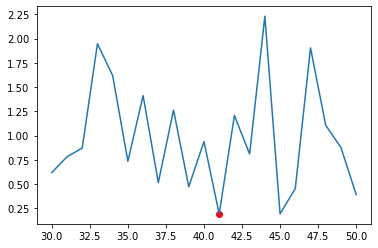

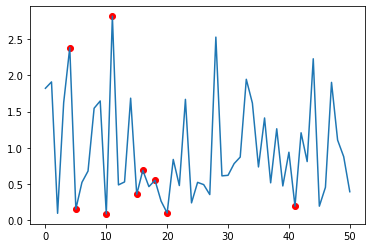

WMTS


c:\Users\baseb\Documents\github\修論\SMOTEMTSBag\MTSBag\code\func\my_func.py:574: RuntimeWarning: divide by zero encountered in double_scalars
  result_df['RS'][m] = (TP / (TP + FN)) / (TN / (TN + FP))


AUC                0.05
accuracy       0.666667
recall              0.7
Specificity         0.0
precision      0.933333
gmeans              0.0
RS                  inf
Name: 0, dtype: object

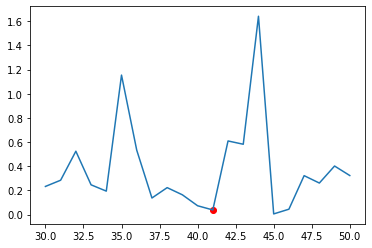

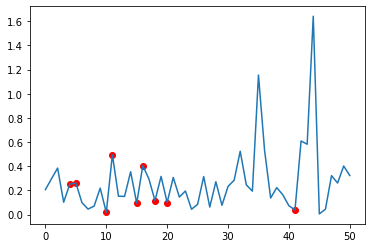

logistic


c:\Users\baseb\Documents\github\修論\SMOTEMTSBag\MTSBag\code\func\my_func.py:574: RuntimeWarning: divide by zero encountered in double_scalars
  result_df['RS'][m] = (TP / (TP + FN)) / (TN / (TN + FP))


AUC                0.45
accuracy       0.952381
recall              1.0
Specificity         0.0
precision      0.952381
gmeans              0.0
RS                  inf
Name: 0, dtype: object

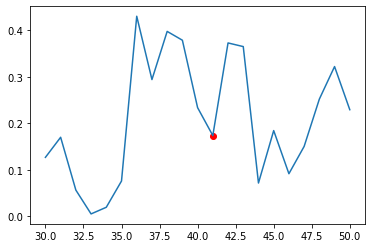

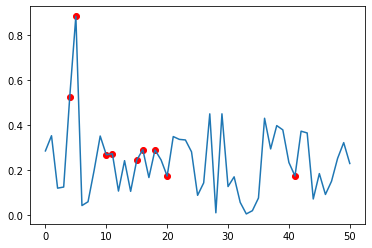

LGBM


c:\Users\baseb\Documents\github\修論\SMOTEMTSBag\MTSBag\code\func\my_func.py:574: RuntimeWarning: divide by zero encountered in double_scalars
  result_df['RS'][m] = (TP / (TP + FN)) / (TN / (TN + FP))


AUC                 0.8
accuracy       0.761905
recall              0.8
Specificity         0.0
precision      0.941176
gmeans              0.0
RS                  inf
Name: 0, dtype: object

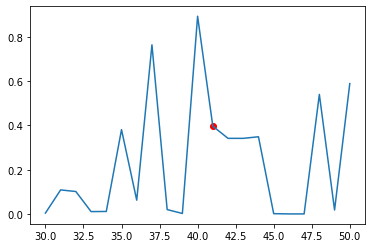

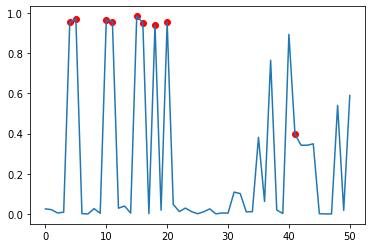

-------------------
1505
-------------------
MTS


AUC             0.426573
accuracy        0.571429
recall          0.863636
Specificity     0.076923
precision       0.612903
gmeans          0.257747
RS             11.227273
Name: 0, dtype: object

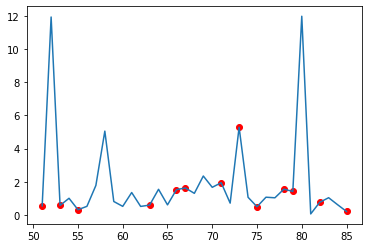

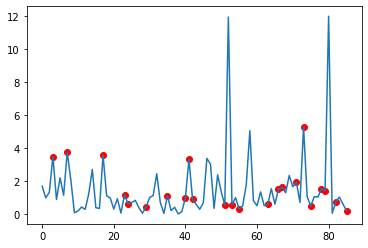

WMTS


AUC            0.433566
accuracy       0.485714
recall         0.454545
Specificity    0.538462
precision         0.625
gmeans         0.494727
RS             0.844156
Name: 0, dtype: object

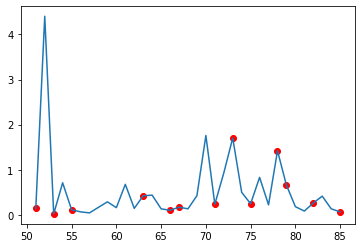

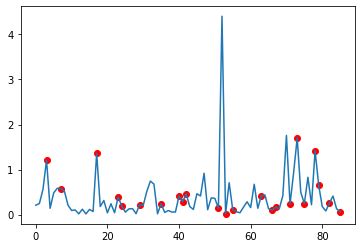

logistic


c:\Users\baseb\anaconda3\envs\convenient\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC             0.423077
accuracy             0.6
recall          0.909091
Specificity     0.076923
precision          0.625
gmeans          0.264443
RS             11.818182
Name: 0, dtype: object

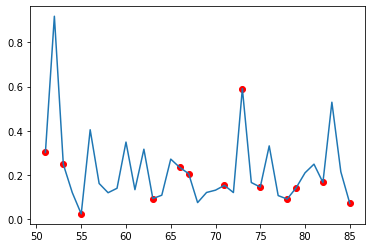

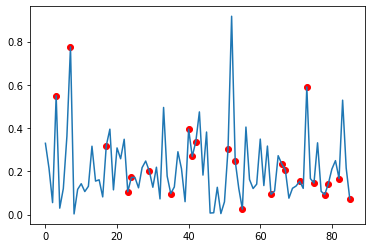

LGBM


AUC            0.461538
accuracy       0.542857
recall         0.727273
Specificity    0.230769
precision      0.615385
gmeans         0.409673
RS             3.151515
Name: 0, dtype: object

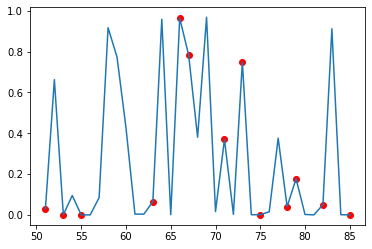

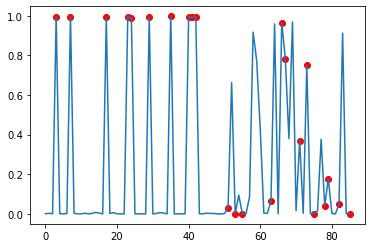

-------------------
1737
-------------------
MTS


AUC                 0.4
accuracy       0.578947
recall         0.333333
Specificity         0.6
precision      0.066667
gmeans         0.447214
RS             0.555556
Name: 0, dtype: object

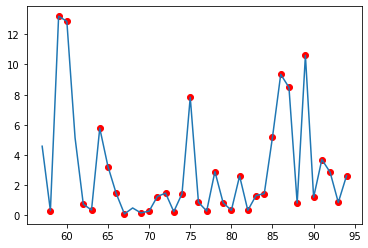

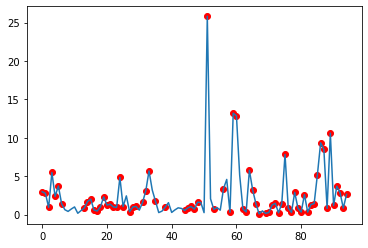

WMTS


AUC            0.295238
accuracy       0.394737
recall         0.333333
Specificity         0.4
precision      0.045455
gmeans         0.365148
RS             0.833333
Name: 0, dtype: object

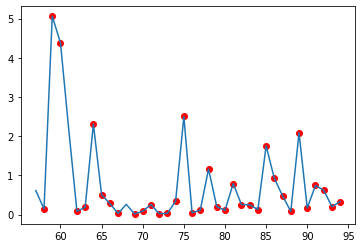

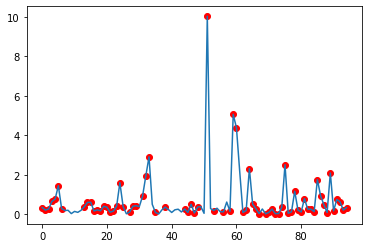

logistic


AUC            0.590476
accuracy       0.894737
recall              0.0
Specificity    0.971429
precision           0.0
gmeans              0.0
RS                  0.0
Name: 0, dtype: object

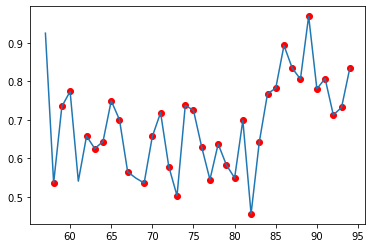

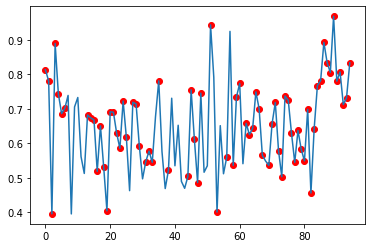

LGBM


AUC            0.390476
accuracy       0.552632
recall         0.333333
Specificity    0.571429
precision        0.0625
gmeans         0.436436
RS             0.583333
Name: 0, dtype: object

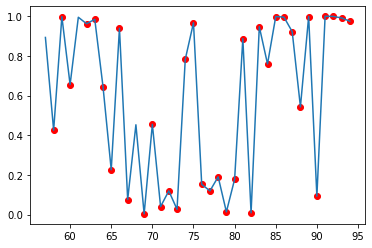

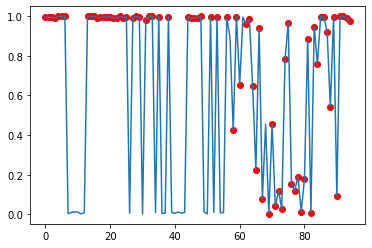

-------------------
1774
-------------------
MTS


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [65]:
for user_id in use_users:
    print('-------------------')
    print(user_id)
    print('-------------------')
    exp(*create_X_y(user_id))